In [32]:
from residual_learning.utils import (
                BaseForecaster, 
                ResidualForecasterDarts,
                TimeSeriesPreprocessor,
                crps,
                HistoricalForecaster
)
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts import TimeSeries
from darts.metrics import smape, rho_risk
import numpy as np
import time
from typing import Optional
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.models import (
                          BlockRNNModel, 
                          TCNModel, 
                          RNNModel, 
                          TransformerModel, 
                          NLinearModel,
                          DLinearModel,
                          NBEATSModel,
                          XGBModel,
                          LinearRegressionModel,
                          TFTModel,
                         )
import optuna
from optuna.integration import PyTorchLightningPruningCallback
import CRPS.CRPS as forecastscore
from datetime import datetime, timedelta


os.environ["CUDA_VISIBLE_DEVICES"] = "1"
targets = pd.read_csv("targets.csv.gz")

The different sites are listed below:

In [2]:
targets["site_id"].unique()

array(['ARIK', 'BARC', 'BIGC', 'BLDE', 'BLUE', 'BLWA', 'CARI', 'COMO',
       'CRAM', 'CUPE', 'FLNT', 'GUIL', 'HOPB', 'KING', 'LECO', 'LEWI',
       'LIRO', 'MART', 'MAYF', 'MCDI', 'MCRA', 'OKSR', 'POSE', 'PRIN',
       'PRLA', 'PRPO', 'REDB', 'SUGG', 'SYCA', 'TECR', 'TOMB', 'TOOK',
       'WALK', 'WLOU'], dtype=object)

Loading the csv's

In [3]:
data_preprocessor = TimeSeriesPreprocessor()
data_preprocessor.load()

Let's first look at BARC which has every target series available

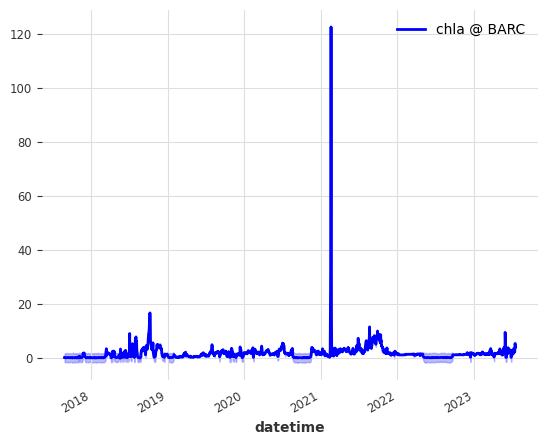

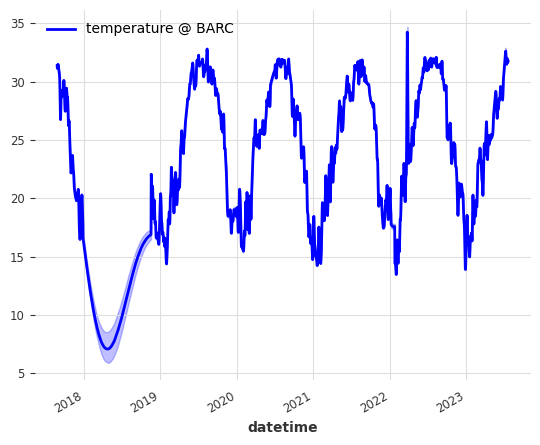

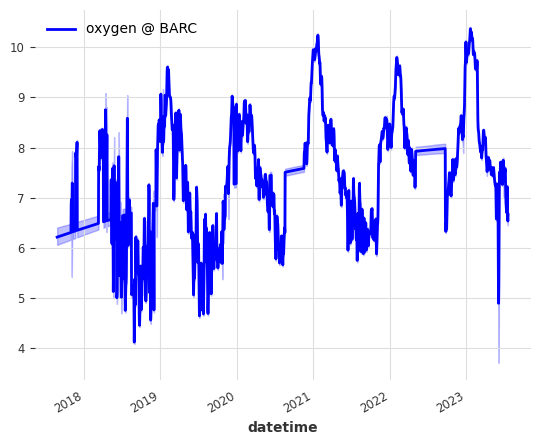

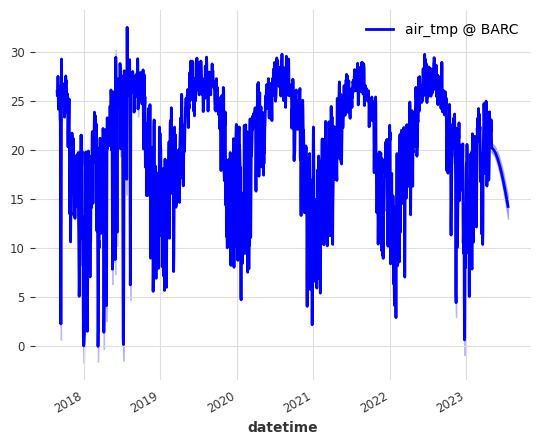

In [3]:
data_preprocessor.plot_by_site("BARC")

After running `python block_rnn.py &` and `python tcn.py &` on command line, let's look at the forecasts. Note this was for oxygen target series at BARC.

Need to make the following class so that it generates samples

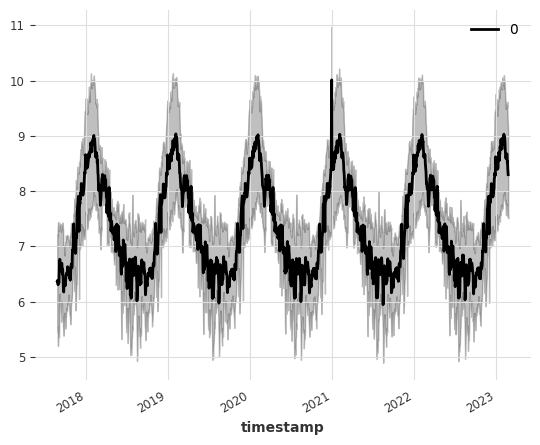

In [37]:
historical_model = HistoricalForecaster(data_preprocessor=data_preprocessor,
                          output_csv_name="historical_forecaster_output.csv",
                          validation_split_date="2023-02-26",
                          forecast_horizon=30,
                          site_id="BARC",
                          target_variable="oxygen")
historical_model.historical_forecasts()
historical_model.historical_forecast.plot()

The work for tomorrow is to make a comparison between historical forecaster and historical forecaster + adjusted residuals

In [328]:
residual_forecaster = ResidualForecasterDarts(
        historical_forecasts=historical_model.historical_forecast,
        historical_ground_truth=historical_model.training_set,
        covariates=None,
        validation_split_date="2023-02-25",
        output_csv_name = "trash_residual_forecaster.csv",
        forecast_horizon=30
)
residual_forecaster.make_residual_forecasts()

{'input_chunk_length': 180}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


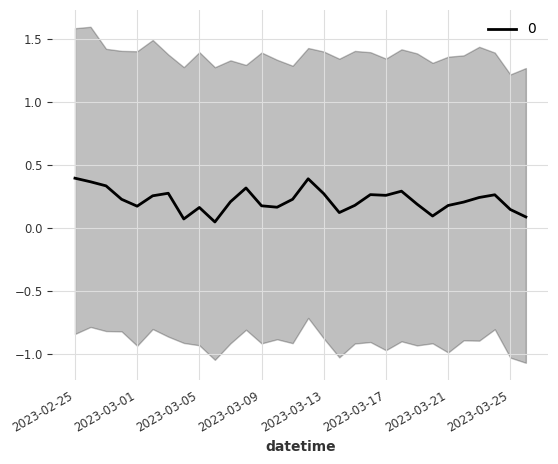

In [329]:
residual_forecaster.predictions.plot()

In [324]:
def stack_ts(timeseries, n_samples=500):
    output = timeseries.copy()
    for i in range(n_samples-1):
        output = output.concatenate(timeseries, axis=2)
    return output

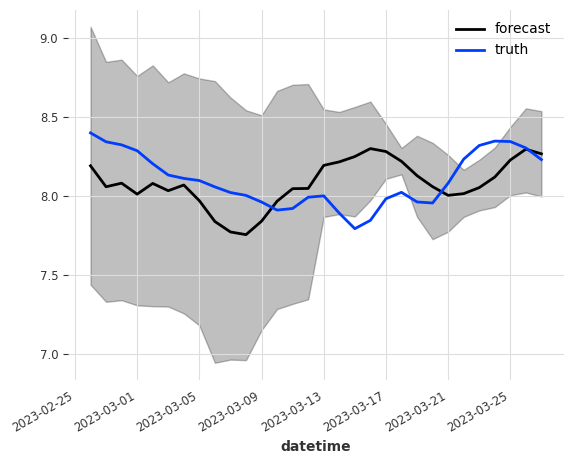

In [38]:
start_date = pd.Timestamp(year=2023, month=2, day=26)
end_date = pd.Timestamp(year=2023, month=3, day=27)
historical_truth = historical_model.validation_set.slice(start_date, end_date)
historical_forecast = historical_model.forecast_ts
historical_forecast.plot(label="forecast")
historical_truth.median().plot(label="truth")
#(stack_ts(historical_forecast.median()) + residual_forecaster.predictions).plot(label="adjusted")

Comparing CRPS of these

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


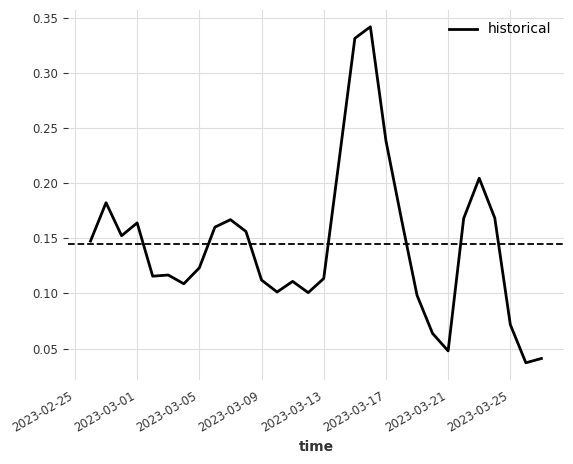

In [73]:
historical_crps = crps(historical_forecast, historical_truth)
#historical_adjusted_crps = crps((stack_ts(historical_forecast.median()) + residual_forecaster.predictions), historical_truth)
plt.clf()
historical_crps.plot(label = "historical")
plt.axhline(y = historical_crps.mean(axis=0).values()[0][0], color = 'black', linestyle = '--')
#historical_adjusted_crps.plot(label = "historical + residual")
#plt.axhline(y = historical_adjusted_crps.mean(axis=0).values()[0][0], color = 'blue', linestyle = '--')

Function to create a plot comparing forecast, historical and observed data.

In [186]:
forecasts_dict = {}

In [110]:
def make_plot(csv_name, site, target_variable, data_preprocessor, record_dict):
    # Loading the forecast csv and creating a time series
    df = pd.read_csv(f"{csv_name}.csv")
    times = pd.to_datetime(df["datetime"])
    times = pd.DatetimeIndex(times)
    values = df.loc[:, df.columns!="datetime"].to_numpy().reshape((len(times), 1, -1))
    model_forecast = TimeSeries.from_times_and_values(times, 
                                                      values, 
                                                      fill_missing_dates=True, freq="D")

    # Presuming data_preprocessor has been called outside of the function
    # (not the best practice), create a validation series from it
    target_series = data_preprocessor.sites_dict[site][target_variable]
    validation_series = target_series.slice(times[0], times[-1]).median()

    # Now, making the forecast based off of historical mean and std
    historical_model = HistoricalForecaster(data_preprocessor=data_preprocessor,
                          output_csv_name="historical_forecaster_output.csv",
                          validation_split_date=str(model_forecast.time_index[0])[:10],
                          forecast_horizon=30,
                          site_id=site,
                          target_variable=target_variable)
    historical_model.make_forecasts()
    
    if site not in record_dict.keys():
        record_dict[site] = {target_variable: {csv_name: model_forecast}}
        record_dict[site][target_variable]["validation"] = validation_series
        # I need to make draw samples from historical would be best to just do this in utils
        record_dict[site][target_variable]["historical"] = historical_model.forecast_ts
    else:
        record_dict[site][target_variable][csv_name] = model_forecast    
    
    validation_series.plot(label="Truth")
    model_forecast.plot(label="Forecast")
    historical_model.forecast_ts.plot(label="historical")

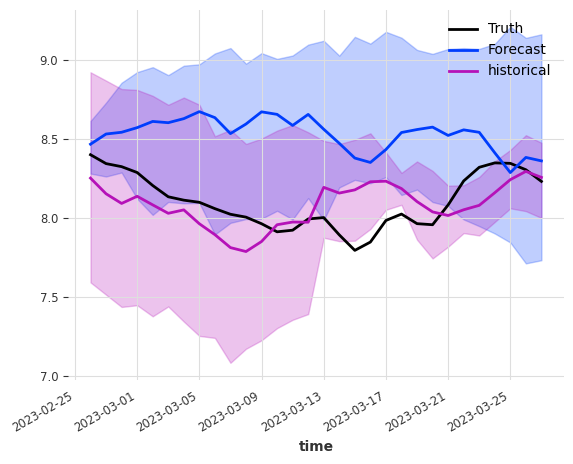

In [188]:
make_plot("block_rnn", "BARC", "oxygen", forecasts_dict)

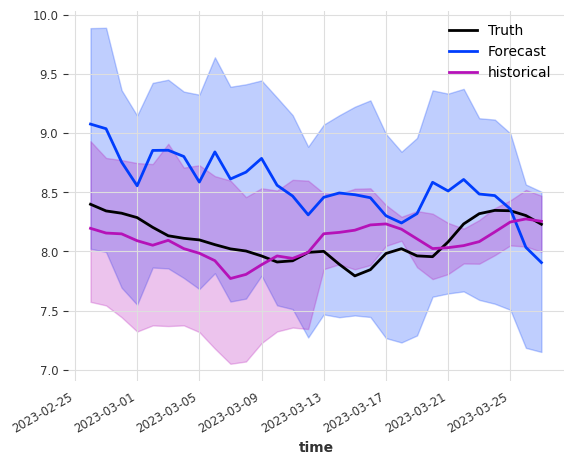

In [189]:
make_plot("tcn", "BARC", "oxygen", forecasts_dict)

Now plotting Crps scores.

In [17]:
import random

def make_crps_plot(forecast_dict, observed):
    crps_scores = {}
    for model_name, forecast in forecast_dict.items():
        _crps = crps(forecast, observed)
        crps_scores[model_name] = _crps

    plt.clf()
    for model_name, crps_score in crps_scores.items():
        random_color = (random.random(), random.random(), random.random())
        crps_score.plot(label=model_name, color=random_color)
        plt.axhline(y=crps_score.mean(axis=0).values()[0][0],  
                    linestyle="--", 
                    color=random_color)
    plt.show()
        

In [29]:
forecast_dict = {"block_rnn" : forecasts_dict["BARC"]["oxygen"]["block_rnn"],
                 "tcn": forecasts_dict["BARC"]["oxygen"]["tcn"],
                 "historical": forecasts_dict["BARC"]["oxygen"]["historical"]}
make_crps_plot(forecast_dict, forecasts_dict["BARC"]["oxygen"]["validation"])

NameError: name 'forecasts_dict' is not defined

And, now with SMAPE

In [33]:
def smape_comparison(forecast_list, observed):
    smape_scores = []
    for forecast in forecast_list:
        _smape = smape(forecast, observed, n_jobs=-1, verbose=False)
        smape_scores.append(_smape)
    scores = ", ".join(map(str, smape_scores))
    print(f"Smape scores: {scores}")

In [360]:
smape_comparison(forecast_list, forecasts_dict["BARC"]["oxygen"]["validation"])

Smape scores: 5.18028470325917, 5.826564064041284, 1.9122326174847306


And, with rho risk

In [355]:
def rho_comparison(forecast_list, observed):
    for rho in [.05, .5, .95]:
        rho_scores = []
        for forecast in forecast_list:
            score = rho_risk(observed, forecast, rho=rho, verbose=False)
            rho_scores.append(score)
        scores = ", ".join(map(str, rho_scores))
        print(f"Rho Risk at {rho}: {scores}")

In [356]:
forecast_list = [forecasts_dict["BARC"]["oxygen"]["block_rnn"],
                 forecasts_dict["BARC"]["oxygen"]["tcn"], 
                 forecasts_dict["BARC"]["oxygen"]["historical"]]
rho_comparison(forecast_list, forecasts_dict["BARC"]["oxygen"]["validation"])

Rho Risk at 0.05: 0.08126538384662846, 0.053911427992865184, 0.0014966581552925146
Rho Risk at 0.5: 0.0533452282821601, 0.04693386112683963, 0.002850742501799412
Rho Risk at 0.95: 0.0064216792762933515, 0.006512460441479214, 0.0009123929066245629


# Trying to use historical mean and std as covariates

In [6]:
forecaster_hist_test = BaseForecasterHistPlus(model="BlockRNN",
                                      data_preprocessor=data_preprocessor,
                                      target_variable_column_name="oxygen",
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "chla", "temperature"],
                                      output_csv_name="trash_hist_test.csv",
                                      validation_split_date="2023-03-01",
                                      model_hyperparameters={'input_chunk_length': 540, 
                                                             'hidden_dim': 16, 
                                                             'model': 'GRU', 
                                                             'n_rnn_layers': 4},
                                      model_likelihood={"likelihood": QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95])},
                                      forecast_horizon=30,
                                      site_id="ARIK",
                                      historical_covariates=True,)
forecaster_hist_test.make_forecasts()

{'input_chunk_length': 540, 'hidden_dim': 16, 'model': 'GRU', 'n_rnn_layers': 4}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [412]:
forecaster_hist_null = BaseForecasterHistPlus(model="BlockRNN",
                                      data_preprocessor=data_preprocessor,
                                      target_variable_column_name="oxygen",
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "chla", "temperature"],
                                      output_csv_name="trash_null.csv",
                                      validation_split_date="2023-03-01",
                                      model_hyperparameters={'input_chunk_length': 540, 
                                                             'hidden_dim': 16, 
                                                             'model': 'GRU', 
                                                             'n_rnn_layers': 4},
                                      model_likelihood={"likelihood": QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95])},
                                      forecast_horizon=30,
                                      site_id="ARIK",
                                      historical_covariates=False,)

forecaster_hist_null.make_forecasts()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


{'input_chunk_length': 180}


`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


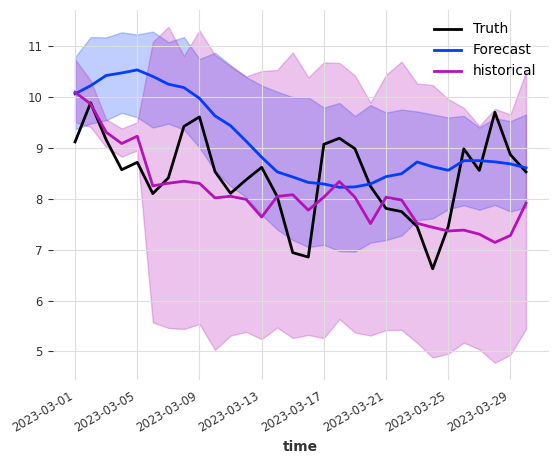

In [13]:
make_plot("trash_hist_test", "ARIK", "oxygen", data_preprocessor, _record_dict)

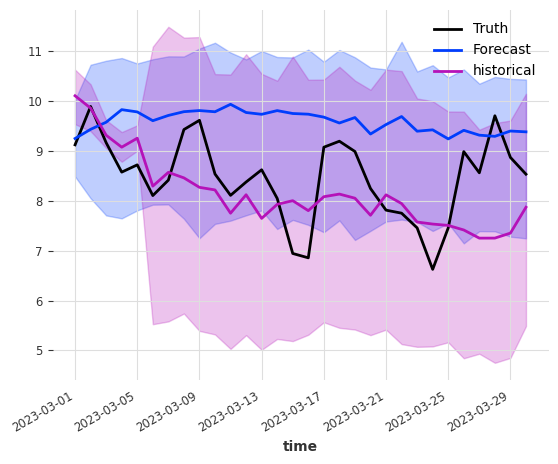

In [15]:
make_plot("trash_null", "ARIK", "oxygen", data_preprocessor, _record_dict)

In [26]:
_record_dict['ARIK']['oxygen']['historical']

<TimeSeries (DataArray) (time: 30, component: 1, sample: 500)>
array([[[10.34037871, 10.14766136, 10.57177514, ..., 10.18338081,
         10.0045732 , 10.22230618]],

       [[ 9.47650303,  9.73758696,  9.96883718, ...,  9.7806702 ,
          9.65026718,  9.7726628 ]],

       [[ 9.37875477,  9.10097954,  9.32371692, ...,  9.11592194,
          9.29203356,  9.51629501]],

       ...,

       [[ 3.67727998,  7.81783534,  6.03691316, ...,  7.55934218,
          5.80721448,  7.86432448]],

       [[ 7.71320783,  7.16841582,  8.22299212, ...,  5.85854882,
          5.70869221,  5.53569029]],

       [[ 9.10939805, 10.2965618 ,  9.51741886, ...,  8.85622282,
         12.15081882,  9.73852307]]])
Coordinates:
  * time       (time) datetime64[ns] 2023-03-01 2023-03-02 ... 2023-03-30
  * component  (component) <U1 '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [34]:
forecast_list = [_record_dict['ARIK']['oxygen']['trash_null'],
                 _record_dict['ARIK']['oxygen']['trash_hist_test'],
                 _record_dict['ARIK']['oxygen']['historical']]
smape_comparison(forecast_list, _record_dict["ARIK"]["oxygen"]["validation"])

Smape scores: 13.52440555339403, 10.807318970662221, 8.793811266010659


You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


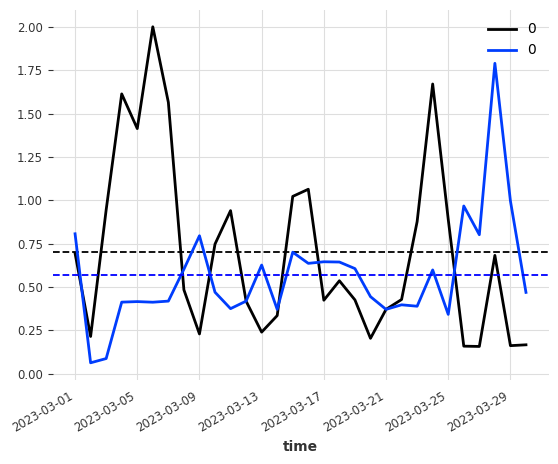

In [32]:
score = crps(_record_dict["ARIK"]['oxygen']['trash_hist_test'], _record_dict["ARIK"]["oxygen"]["validation"])
hist_score = crps(_record_dict['ARIK']['oxygen']['historical'], _record_dict["ARIK"]["oxygen"]["validation"])
score.plot()
plt.axhline(y = score.mean(axis=0).values()[0][0], color = 'black', linestyle = '--')
hist_score.plot()
plt.axhline(y = hist_score.mean(axis=0).values()[0][0], color = 'blue', linestyle = '--')

In [36]:
class BaseForecasterHistPlus():
    def __init__(self,
                 model: Optional[str] = None,
                 data_preprocessor: Optional = None,
                 target_variable_column_name: Optional[str] = None,
                 datetime_column_name: Optional[str] = None,
                 covariates_names: Optional[list] = None,
                 output_csv_name: Optional[str] = "residual_forecaster_output.csv",
                 validation_split_date: Optional[str] = None, #YYYY-MM-DD
                 model_hyperparameters: Optional[dict] = None,
                 model_likelihood: Optional[dict] = None,
                 forecast_horizon: Optional[int] = 30,
                 site_id: Optional[str] = None,
                 historical_covariates: Optional[bool] = False,
                 ):
        self.model_ = {"BlockRNN": BlockRNNModel, 
                       "TCN": TCNModel, 
                       "RNN": RNNModel, 
                       "Transformer": TransformerModel,
                       "NLinear": NLinearModel,
                       "DLinear": DLinearModel,
                       "XGB": XGBModel,
                       "NBEATS": NBEATSModel,
                       "Linear": LinearRegressionModel,
                       "TFT": TFTModel}[model]
        self.data_preprocessor = data_preprocessor
        self.target_variable_column_name = target_variable_column_name
        self.datetime_column_name = datetime_column_name
        self.covariates_names = covariates_names
        self.output_csv_name = output_csv_name
        self.validation_split_date = validation_split_date
        self.forecast_horizon = forecast_horizon
        self.site_id = site_id
        if model_hyperparameters == None:
            self.hyperparams = {"input_chunk_length" : 180}
        else:
            self.hyperparams = model_hyperparameters
        self.model_likelihood = model_likelihood
        self.historical_covariates = historical_covariates

        self._preprocess_data()
        
    def _preprocess_data(self):
        """
        Performs gap filling and processing of data into format that
        Darts models will accept
        """
        stitched_series_dict = self.data_preprocessor.sites_dict[self.site_id]

        # If there was failure when doing the GP fit then we can't do preprocessing
        if self.target_variable_column_name in \
                self.data_preprocessor.sites_dict_null[self.site_id]:
            return "Cannot fit this target time series as no GP fit was performed."
        self.inputs = stitched_series_dict[self.target_variable_column_name]

        # And not using the covariates that did not yield GP fits beforehand
        for null_variable in self.data_preprocessor.sites_dict_null[self.site_id]:
            self.covariates_names.remove(null_variable)
            
        # Initializing covariates list then concatenating in for loop
        self.covariates = stitched_series_dict[self.covariates_names[0]]
        for cov_var in self.covariates_names[1:]:
            self.covariates = self.covariates.concatenate(stitched_series_dict[cov_var], 
                                                          axis=1, 
                                                          ignore_time_axis=True)
        
        # Splitting training and validation set
        year = int(self.validation_split_date[:4])
        month = int(self.validation_split_date[5:7])
        day = int(self.validation_split_date[8:])
        split_date = pd.Timestamp(year=year, month=month, day=day)
        self.training_set, self.validation_set = self.inputs.split_before(split_date)
        if self.historical_covariates:
            self.covariates, _ = self.covariates.split_before(split_date)
            self.get_historical_df(self.training_set)
            self.covariates = self.covariates.concatenate(self.historical_samples,
                                                          axis=1,
                                                          ignore_time_axis=True)

    def get_historical_df(self, time_series):
        # Using the medians of the time series
        median_df = time_series.median().pd_dataframe()
        median_df["timestamp"] = pd.to_datetime(median_df.index)
        median_df["day_of_year"] = median_df["timestamp"].dt.dayofyear
        self.median_df = median_df
        
        # Computing average and std for doy's 
        self.doy_df = self.median_df.groupby(['day_of_year'])['0'].agg(['mean', 'std'])
        self.doy_df = self.doy_df.fillna(method="ffill")
        # This produces a new df that gives mean and std for every date (indexed by doy)
        # from the original TimeSeries
        doy_hist_df = self.doy_df.loc[time_series.time_index.dayofyear]

        # Now drawing samples so that we can create a Time Series
        samples = np.array([np.random.normal(doy_hist_df.iloc[i]["mean"], 
                                             doy_hist_df.iloc[i]["std"]/2, 
                                             size=(1,500))
                            for i in range(len(doy_hist_df))])
        # Reconstituting a TimeSeries
        self.historical_samples = TimeSeries.from_times_and_values(
                                                   time_series.time_index,
                                                   samples)

    def tune(self,
             hyperparameter_dict: Optional[dict]
            ):
        """
        Sets up Optuna trial to perform hyperparameter tuning
        Input dictionary will be of the form {"hyperparamter": [values to be tested]}
        """
        # Setting up an optuna Trial
        def objective(trial):
            callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]
            hyperparams = {key: trial.suggest_categorical(key, value) 
                                               for key, value in hyperparameter_dict.items()}
        
            model = self.model_(**hyperparams,
                                output_chunk_length=self.forecast_horizon,
                                **self.model_likelihood)
            
            self.scaler = Scaler()
            training_set, covariates = self.scaler.fit_transform([self.training_set,
                                                                  self.covariates])
            # Don't need to tune XGB and linear regression models
            extras = {"past_covariates": covariates,
                      "verbose": False,
                      "epochs": 500}
        
            model.fit(training_set,
                           **extras)
        
            predictions = model.predict(n=len(self.validation_set[:self.forecast_horizon]), 
                                            past_covariates=covariates, 
                                            num_samples=50)
            predictions = self.scaler.inverse_transform(predictions)
            smapes = smape(self.validation_set[:self.forecast_horizon], 
                           predictions, 
                           n_jobs=-1, 
                           verbose=False)
            
            smape_val = np.mean(smapes)
            return smape_val if smape_val != np.nan else float("inf")

        study = optuna.create_study(direction="minimize")
        
        study.optimize(objective, n_trials=50) # Note 10 trials pretty meaningless here
        
        self.hyperparams = study.best_trial.params

    def make_forecasts(self):
        """
        This function fits a Darts model to the training_set
        """
        print(self.hyperparams)
        self.model = self.model_(**self.hyperparams,
                                 output_chunk_length=self.forecast_horizon,
                                 **self.model_likelihood,
                                 random_state=0)
        self.scaler = Scaler()
        training_set, covariates = self.scaler.fit_transform([self.training_set,
                                                              self.covariates])
        # Need to treat XGB and Linear Regression models differently than networks
        extras = {"past_covariates": covariates,
                  "verbose": False,
                  "epochs": 500}
        if self.model_ == XGBModel or self.model_ == LinearRegressionModel:
            del extras["epochs"]
            del extras["verbose"]
    
        self.model.fit(training_set,
                       **extras)

        predictions = self.model.predict(n=self.forecast_horizon,
                                         past_covariates=covariates, 
                                         num_samples=500)
        predictions = self.scaler.inverse_transform(predictions)

        predictions.pd_dataframe().to_csv(self.output_csv_name)

    def get_historicals_and_residuals(self):
        """
        This function creates a historical forecast along with their residual errors 
        """
        # This presumes that the scaler will not have been modified in interim 
        # from calling `make_forecasts`
        training_set, covariates = self.scaler.transform([self.training_set,
                                                              self.covariates])
        historical_forecasts = self.model.historical_forecasts(
                                            series=training_set,
                                            past_covariates=covariates,
                                            num_samples=500,
                                            forecast_horizon=self.forecast_horizon,
                                            stride=self.forecast_horizon,
                                            retrain=False,
                                            last_points_only=False
                                            )
        historical_forecasts = [self.scaler.inverse_transform(historical_forecast) for
                                                historical_forecast in historical_forecasts]
        # Getting the target time series slice for the historical forecast
        self.historical_ground_truth = self.training_set.slice(
                                            historical_forecasts[0].time_index[0], 
                                            historical_forecasts[-1].time_index[-1])

        # Now concatenating the historical forecasts which were returned
        # as a list above
        self.historical_forecasts = historical_forecasts[0]
        for time_series in historical_forecasts[1:]:
            self.historical_forecasts = self.historical_forecasts.concatenate(time_series, 
                                                                axis=0, 
                                                                ignore_time_axis=True)

        self.residuals = self.historical_ground_truth - self.historical_forecasts

    def make_residuals_csv(self):
        covariates_df = self.covariates.pd_dataframe()
        forecast_df = self.historical_forecasts.pd_dataframe()
        observed_df = self.historical_ground_truth.pd_dataframe()
        residuals_df = self.residuals.pd_dataframe()

        # Creating a folder if it doesn't exist already
        if not os.path.exists(f"{self.model}_residuals/"):
            os.makedirs(f"{self.model}_residuals/")
        # Saving csv's in the **model name**_test directory
        df_dict = {"covariates": block_rnn_forecaster.covariates.pd_dataframe(),
                   "forecast": block_rnn_forecaster.historical_forecasts.pd_dataframe(),
                   "observed": block_rnn_forecaster.historical_ground_truth.pd_dataframe()}
        for variable, df in df_dict.items():
            df.to_csv(f"{self.model}_test/{variable}")

    def plot_by_site(self, site):
        for key in self.sites_dict[site].keys():
            plt.clf()
            self.sites_dict[site][key].plot(color="blue", label=f"{key} @ {site}")
            plt.show()

In [ ]:
forecaster_hist_test = BaseForecasterHistPlus(model="BlockRNN",
                                      data_preprocessor=data_preprocessor,
                                      target_variable_column_name="oxygen",
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "chla", "temperature"],
                                      output_csv_name="trash_hist_test.csv",
                                      validation_split_date="2023-03-01",
                                      model_hyperparameters={'input_chunk_length': 540, 
                                                             'hidden_dim': 16, 
                                                             'model': 'GRU', 
                                                             'n_rnn_layers': 4,
                                                             'add_encoders': {'datetime_attribute': {'future': ['dayofyear'],
                                                                                                     'past': ['dayofyear']}}},
                                      model_likelihood={"likelihood": QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95])},
                                      forecast_horizon=30,
                                      site_id="ARIK",
                                      historical_covariates=True,)
forecaster_hist_test.make_forecasts()

In [85]:
forecaster_hist_test = BaseForecasterHistPlus(model="TFT",
                                      data_preprocessor=data_preprocessor,
                                      target_variable_column_name="oxygen",
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "chla", "temperature"],
                                      output_csv_name="trash_hist_test.csv",
                                      validation_split_date="2023-03-01",
                                      model_hyperparameters={'input_chunk_length': 540,  
                                                             'lstm_layers': 4,
                                                             'add_encoders': {'datetime_attribute': {'future': ['dayofyear']}}},
                                      model_likelihood={"likelihood": QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95])},
                                      forecast_horizon=30,
                                      site_id="ARIK",
                                      historical_covariates=True,)
forecaster_hist_test.make_forecasts()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


{'input_chunk_length': 540, 'lstm_layers': 4, 'add_encoders': {'datetime_attribute': {'future': ['dayofyear']}}}


`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [108]:
from darts.explainability import TFTExplainer

explainer = TFTExplainer(forecaster_hist_test)
explainer.explain()

ImportError: cannot import name 'TFTExplainer' from 'darts.explainability' (/home/rstudio/.local/lib/python3.10/site-packages/darts/explainability/__init__.py)

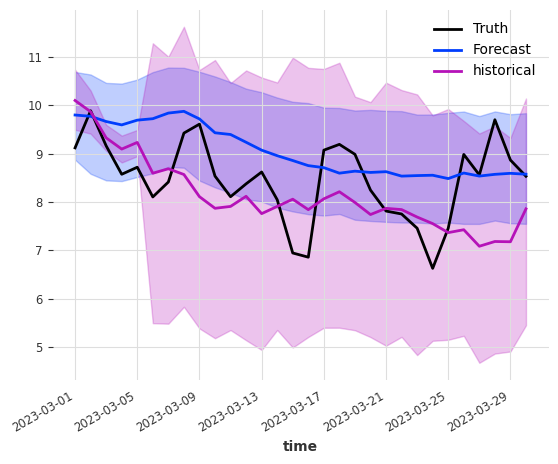

In [117]:
make_plot("trash_hist_test", "ARIK", "oxygen", data_preprocessor, _record_dict)

In [26]:
def crps(forecast, observed):
    """
    Returns an array of CRPS scores 
    """
    forecast_array = forecast.pd_dataframe().values
    observed_array = observed.median().pd_series().values

    crps_scores = []
    for i in range(len(forecast_array)):
        # Note forecastscore is CRPS.CRPS
        crps, _, __ = forecastscore(forecast_array[i], observed_array[i]).compute()
        crps_scores.append(crps)

    crps_scores = TimeSeries.from_times_and_values(forecast.time_index, 
                                     crps_scores, 
                                     fill_missing_dates=True, freq="D")
    return crps_scores

In [96]:
def smape_comparison(forecast_list, observed):
    smape_scores = []
    for forecast in forecast_list:
        _smape = smape(forecast, observed, n_jobs=-1, verbose=False)
        smape_scores.append(_smape)
    scores = ", ".join(map(str, smape_scores))
    print(f"Smape scores: {scores}")

In [102]:
forecast_list = [_record_dict["ARIK"]['oxygen']['trash_hist_test'], _record_dict['ARIK']['oxygen']['historical']]
smape_comparison(forecast_list, _record_dict["ARIK"]["oxygen"]["validation"])

Smape scores: 9.506398933139739, 8.793811266010659


You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


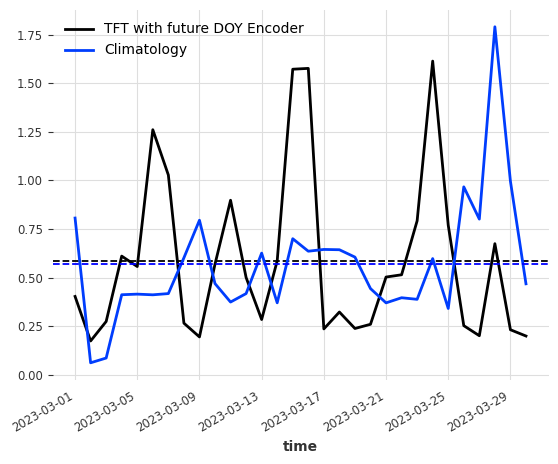

In [170]:
score = crps(_record_dict["ARIK"]['oxygen']['trash_hist_test'], _record_dict["ARIK"]["oxygen"]["validation"])
hist_score = crps(_record_dict['ARIK']['oxygen']['historical'], _record_dict["ARIK"]["oxygen"]["validation"])
score.plot(label = "TFT with future DOY Encoder")
plt.axhline(y = score.mean(axis=0).values()[0][0], color = 'black', linestyle = '--')
hist_score.plot(label = "Climatology")
plt.axhline(y = hist_score.mean(axis=0).values()[0][0], color = 'blue', linestyle = '--')

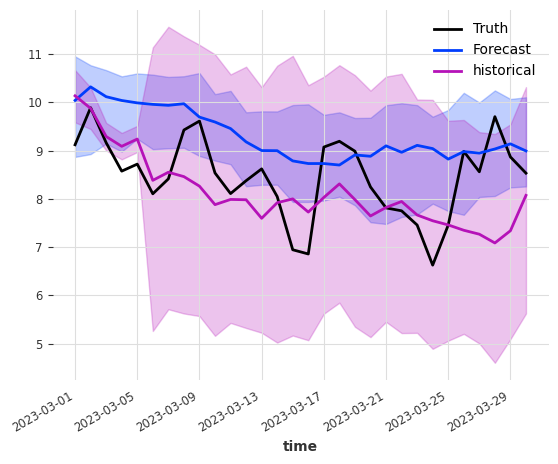

In [116]:
make_plot("trash_block_test", "ARIK", "oxygen", data_preprocessor, _record_dict)

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


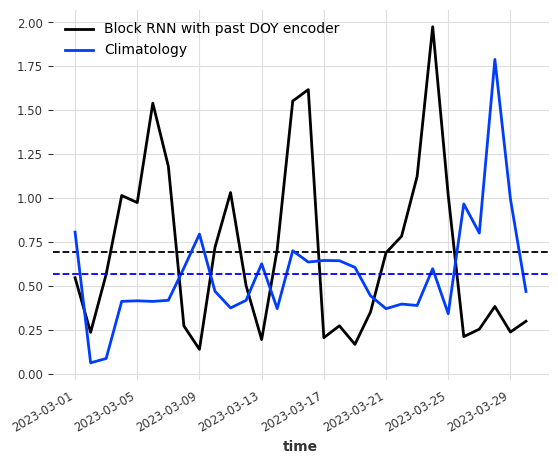

In [169]:
score = crps(_record_dict["ARIK"]['oxygen']['trash_block_test'], _record_dict["ARIK"]["oxygen"]["validation"])
hist_score = crps(_record_dict['ARIK']['oxygen']['historical'], _record_dict["ARIK"]["oxygen"]["validation"])
score.plot(label = "Block RNN with past DOY encoder")
plt.axhline(y = score.mean(axis=0).values()[0][0], color = 'black', linestyle = '--')
hist_score.plot(label = "Climatology")
plt.axhline(y = hist_score.mean(axis=0).values()[0][0], color = 'blue', linestyle = '--')

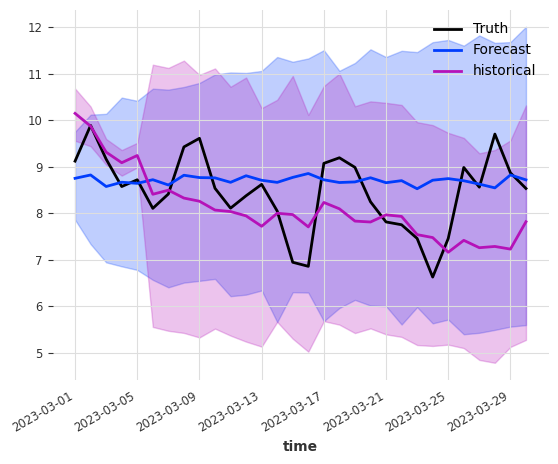

In [166]:
make_plot("trash_arima", "ARIK", "oxygen", data_preprocessor, _record_dict)

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().
You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


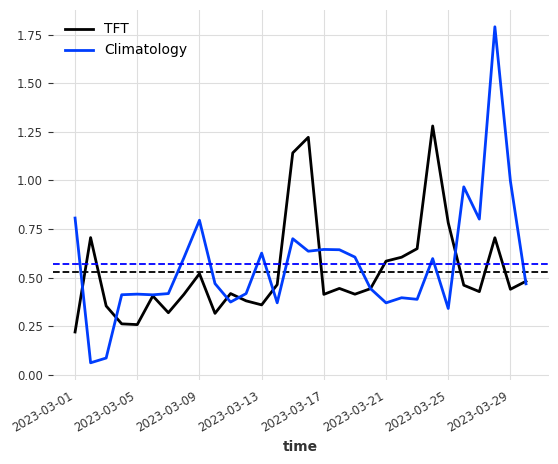

In [168]:
score = crps(_record_dict["ARIK"]['oxygen']['trash_arima'], _record_dict["ARIK"]["oxygen"]["validation"])
hist_score = crps(_record_dict['ARIK']['oxygen']['historical'], _record_dict["ARIK"]["oxygen"]["validation"])
score.plot(label = "TFT")
plt.axhline(y = score.mean(axis=0).values()[0][0], color = 'black', linestyle = '--')
hist_score.plot(label = "Climatology")
plt.axhline(y = hist_score.mean(axis=0).values()[0][0], color = 'blue', linestyle = '--')

In [ ]:
forecaster_hist_test = BaseForecasterHistPlus(model="TFT",
                                      data_preprocessor=data_preprocessor,
                                      target_variable_column_name="oxygen",
                                      datetime_column_name="datetime",
                                      covariates_names=["air_tmp", "chla", "temperature"],
                                      output_csv_name="trash_hist_test.csv",
                                      validation_split_date="2023-03-01",
                                      model_hyperparameters={'input_chunk_length': 540,  
                                                             'lstm_layers': 4,
                                                             'add_encoders': {'datetime_attribute': {'future': ['dayofyear']}}},
                                      model_likelihood={"likelihood": QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95])},
                                      forecast_horizon=30,
                                      site_id="ARIK",
                                      historical_covariates=True,)
forecaster_hist_test.make_forecasts()

Checking Exponential smoothing really quick

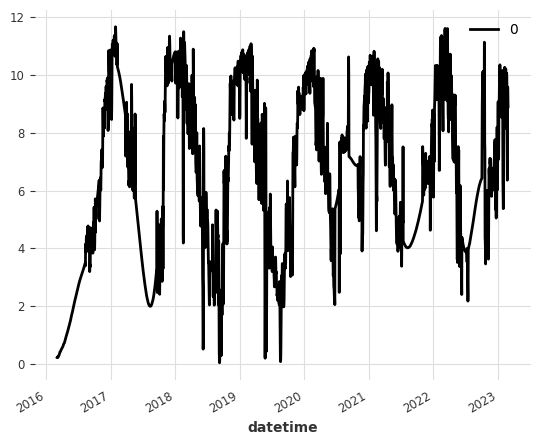

In [133]:
forecaster_hist_test.training_set.median().plot()

In [162]:
from darts.models import StatsForecastAutoARIMA

tr_set = forecaster_hist_test.training_set.median()
stats_model = StatsForecastAutoARIMA()
stats_model.fit(tr_set)
preds = stats_model.predict(30, num_samples=500)

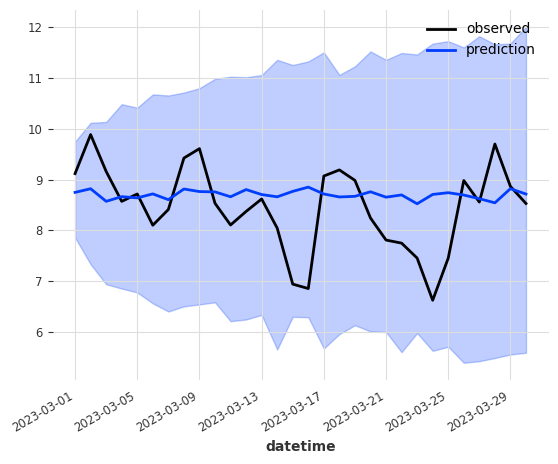

In [163]:
_record_dict['ARIK']['oxygen']['validation'].plot(label="observed")
preds.plot(label="prediction")

In [165]:
preds.pd_dataframe().to_csv("trash_arima.csv")

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [4]:
class ResidualForecasterDartsTFT():
    def __init__(self,
                 residuals: Optional[TimeSeries] = None,
                 output_csv_name: Optional[str] = "residual_forecaster_output.csv",
                 validation_split_date: Optional[str] = None, #YYYY-MM-DD
                 tune_model: Optional[bool] = False,
                 model_hyperparameters: Optional[dict] = None,
                 forecast_horizon: Optional[int] = 30
                 ):
        self.residuals = residuals
        self.output_csv_name = output_csv_name
        self.validation_split_date = validation_split_date
        self.forecast_horizon = forecast_horizon
        if model_hyperparameters == None:
            self.hyperparams = {"input_chunk_length": 540,
                                "lstm_layers": 4,
                                "add_encoders": {'datetime_attribute': {'future': ['dayofyear']}}
                                }
        else:
            self.hyperparams = model_hyperparameters
        self._preprocess_data()
 
        
    def _preprocess_data(self):
        """
        Divides input time series into training and validation sets
        """
        # Getting the date so that we can create the training and test set
        year = int(self.validation_split_date[:4])
        month = int(self.validation_split_date[5:7])
        day = int(self.validation_split_date[8:])
        split_date = pd.Timestamp(year=year, month=month, day=day)
        self.training_set, self.validation_set = self.residuals.split_before(split_date)

    
    def tune(self,
             input_chunk_length: Optional[list] = [31, 60, 180, 356],
             hidden_size: Optional[list] = [2, 3, 5],
             num_attention_heads: Optional[list] = [2, 4, 8, 16],
             lstm_layers: Optional[list] = [1, 2, 3],
             dropout: Optional[list] = [0, 0.1, 0.2, 0.3],
             ):
        """
        Sets up Optuna trial to perform hyperparameter tuning
        """
        # The objective function will be called in the optuna loop
        def objective(trial):
            callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]
        
            # Selecting the hyperparameters
            input_chunk_length_ = trial.suggest_categorical("input_chunk_length", 
                                                               input_chunk_length)
            hidden_size_ = trial.suggest_categorical("hidden_size", hidden_size)
            num_attention_heads_ = trial.suggest_categorical("num_attention_heads", num_attention_heads)
            lstm_layers_ = trial.suggest_categorical("lstm_layers", lstm_layers)
            dropout_ = trial.suggest_categorical("dropout", dropout)

            tft_model = TFTModel(input_chunk_length=input_chunk_length_,
                            hidden_size=hidden_size_,
                            num_attention_heads=num_attention_heads_,
                            lstm_layers=lstm_layers_,
                            output_chunk_length=self.forecast_horizon,
                            likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
                            add_encoders={'datetime_attribute': {'future': ['dayofyear']}})

            # Normalizing data to 0, 1 scale and fitting the model
            self.scaler = Scaler()
            training_set = self.scaler.fit_transform(self.training_set)
            tft_model.fit(training_set,
                          epochs=400, 
                          verbose=False)

            predictions = tft_model.predict(n=len(self.validation_set[:self.forecast_horizon]),  
                                            num_samples=50)
            predictions = self.scaler.inverse_transform(predictions)
            
            smapes = smape(self.validation_set[:self.forecast_horizon], 
                           predictions, 
                           n_jobs=-1, 
                           verbose=False)
            
            smape_val = np.mean(smapes)
            return smape_val if smape_val != np.nan else float("inf")


        study = optuna.create_study(direction="minimize")
        
        study.optimize(objective, n_trials=50) # INCREASE NUMBER OF TRIALS LATER ON
        
        # I save the best hyperparameters to the object self.hyperparameter so that these
        # hyperparameters can be easily referend in the future
        self.hyperparams = study.best_trial.params

    def make_residual_forecasts(self):
        """
        This function fits a TCN model to the residual error
        """
        # For clarity, I print the hyperparameters. Otherwise, following the standard
        # model fitting steps in Darts
        print(self.hyperparams)
        tft = TFTModel(**self.hyperparams,
               output_chunk_length=self.forecast_horizon,
               likelihood=QuantileRegression([0.05, 0.1, 0.5, 0.9, 0.95]),
               random_state=0)
        self.scaler = Scaler()
        training_set = self.scaler.fit_transform(self.training_set)
        tft.fit(training_set,
                epochs=500, 
                verbose=False)

        predictions = tft.predict(n=self.forecast_horizon,
                                  num_samples=500)
        self.predictions = self.scaler.inverse_transform(predictions)

        self.predictions.pd_dataframe().to_csv(self.output_csv_name)

In [5]:
class HistoricalForecaster():
    def __init__(self,
                 data_preprocessor: Optional = None,
                 output_csv_name: Optional[str] = "historical_forecaster_output.csv",
                 validation_split_date: Optional[str] = None, #YYYY-MM-DD
                 forecast_horizon: Optional[int] = 30,
                 site_id: Optional[str] = None,
                 target_variable: Optional[str] = None,
                 ):
        self.data_preprocessor = data_preprocessor
        self.output_csv_name = output_csv_name
        self.validation_split_date = validation_split_date
        self.forecast_horizon = forecast_horizon
        self.site_id = site_id
        self.target_variable = target_variable
        self._preprocess_data()
        # Using the medians of the GP filter
        median_df = self.training_set.median().pd_dataframe()
        median_df["timestamp"] = pd.to_datetime(median_df.index)
        median_df["day_of_year"] = median_df["timestamp"].dt.dayofyear
        
        # Computing average and std for doy's 
        self.doy_df = median_df.groupby(['day_of_year'])['0'].agg(['mean', 'std'])

    def _preprocess_data(self):
        stitched_series_dict = self.data_preprocessor.sites_dict[self.site_id]
        # If there was failure when doing the GP fit then we can't do preprocessing
        if self.target_variable in \
                self.data_preprocessor.sites_dict_null[self.site_id]:
            return "Cannot fit this target time series as no GP fit was performed."
        self.inputs = stitched_series_dict[self.target_variable]

        # Splitting training and validation set
        self.year = int(self.validation_split_date[:4])
        month = int(self.validation_split_date[5:7])
        day = int(self.validation_split_date[8:])
        split_date = pd.Timestamp(year=self.year, month=month, day=day)
        self.training_set, self.validation_set = self.inputs.split_before(split_date)

    def make_forecasts(self):
        """
        This function finds the historical mean and var, and uses these statistics for
        the forecast
        """
        # Filtering the previously computed averages and std for our dates of interest
        forecast_doys = pd.date_range(start=self.validation_split_date, 
                                      periods=self.forecast_horizon, 
                                      freq='D').dayofyear
        forecast_df = self.doy_df.loc[forecast_doys]

        # Function to give date from the numerical doy
        def day_of_year_to_date(year, day_of_year):
            base_date = datetime(year, 1, 1)
            target_date = base_date + timedelta(days=day_of_year - 1)
            return target_date

        samples = np.array([np.random.normal(self.doy_df.loc[self.doy_df.index == doy]["mean"],
                                    self.doy_df.loc[self.doy_df.index == doy]["std"]/2,
                                    size=(1, 500)) for doy in forecast_df.index])

        # Now creating an index going from doy to date
        date_index = [day_of_year_to_date(self.year, day) for day in forecast_df.index]
        forecast_df.index = date_index

        
        self.forecast_df = forecast_df
        self.forecast_ts = TimeSeries.from_times_and_values(forecast_df.index, samples)

    def plot(self):
        fig, ax1 = plt.subplots()
        ax1.plot(self.forecast_df.index, 
                 self.forecast_df["mean"], 
                 label="historical",
                 linewidth=2)
        ax1.fill_between(self.forecast_df.index, 
                         self.forecast_df["mean"] - self.forecast_df["std"], 
                         self.forecast_df["mean"] + self.forecast_df["std"],
                         alpha=0.2,)
        fig.autofmt_xdate()
        plt.legend()

    def get_residuals(self):
        residual_list = []
        # Going through each date and finding the difference between the doy historical mean and
        # the observed value
        for date in self.training_set.time_index:
            doy = date.dayofyear
            observed = self.training_set.slice_n_points_after(date, 1).median().values()[0][0]
            historical_mean = self.doy_df.loc[doy]["mean"]
            residual = observed - historical_mean
            residual_list.append(residual)

        self.residuals = TimeSeries.from_times_and_values(self.training_set.time_index, residual_list) 

        

In [6]:
historical_model = HistoricalForecaster(data_preprocessor=data_preprocessor,
                          output_csv_name="historical_forecaster_output.csv",
                          validation_split_date="2023-03-02",
                          forecast_horizon=30,
                          site_id="ARIK",
                          target_variable="oxygen")

historical_model.get_residuals()

In [197]:
historical_model.residuals.time_index[-1]

Timestamp('2023-03-01 00:00:00', freq='D')

In [17]:
x = historical_model.validation_set[:30].median()

In [8]:
tft_residual =  ResidualForecasterDartsTFT(residuals = historical_model.residuals,
                 output_csv_name="tft_residuals.csv",
                 validation_split_date="2023-03-01", #YYYY-MM-DD
                 tune_model=False,
                 forecast_horizon=30,
                 model_hyperparameters={'input_chunk_length': 180, 
                                        'hidden_size': 3, 
                                        'num_attention_heads': 2, 
                                        'lstm_layers': 3, 
                                        'dropout': 0.2,
                                        "add_encoders":{'datetime_attribute': {'future': ['dayofyear']}}}
                 )
#tft_residual.tune()
tft_residual.make_residual_forecasts()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


{'input_chunk_length': 180, 'hidden_size': 3, 'num_attention_heads': 2, 'lstm_layers': 3, 'dropout': 0.2, 'add_encoders': {'datetime_attribute': {'future': ['dayofyear']}}}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
`Trainer.fit` stopped: `max_epochs=500` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Predicting: 0it [00:00, ?it/s]

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


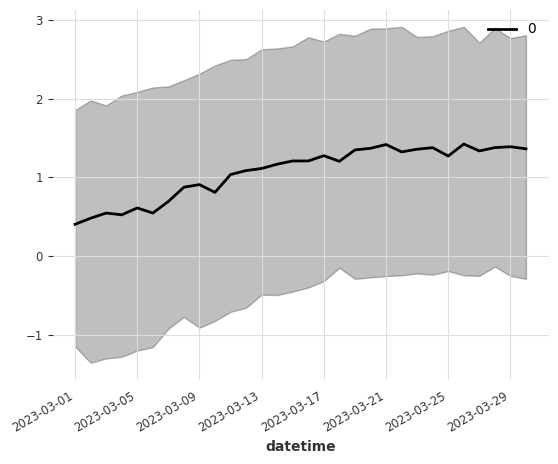

In [13]:
tft_residual.predictions.plot()

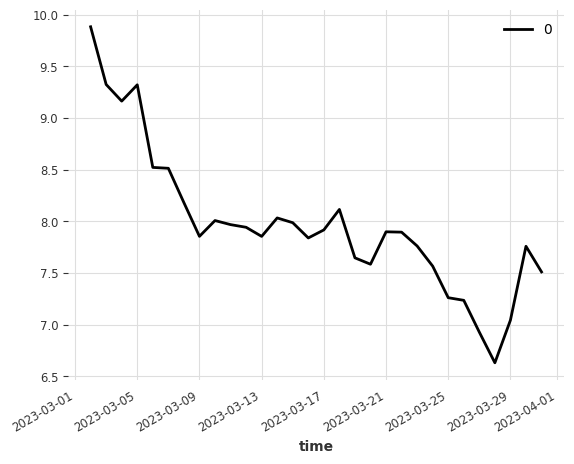

In [23]:
historical_model.forecast_ts.median().plot()

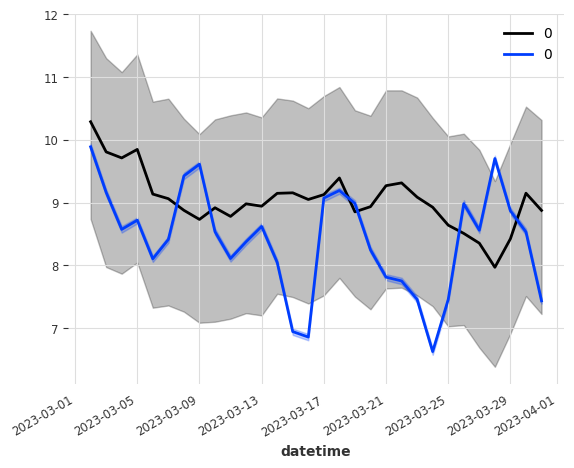

In [31]:
x = stack_ts(historical_model.forecast_ts.median(), 500)
(x + tft_residual.predictions).plot()
historical_model.validation_set[:30].plot()

In [10]:
def stack_ts(timeseries, n_samples=500):
    output = timeseries.copy()
    for i in range(n_samples-1):
        output = output.concatenate(timeseries, axis=2)
    return output

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


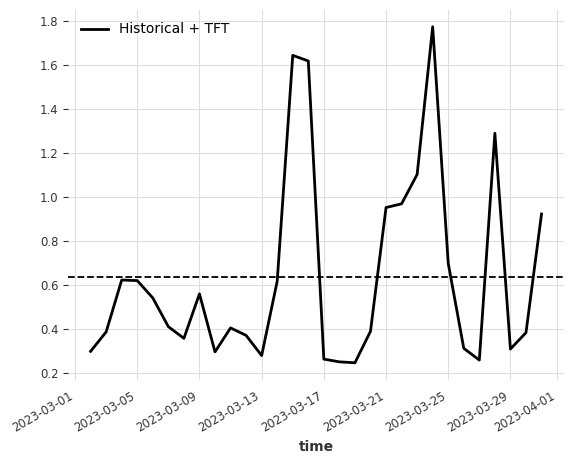

In [28]:
tft_score = crps((x + tft_residual.predictions), historical_model.validation_set[:30])
tft_score.plot(label = "Historical + TFT")
plt.axhline(y = tft_score.mean(axis=0).values()[0][0], color = 'black', linestyle = '--')

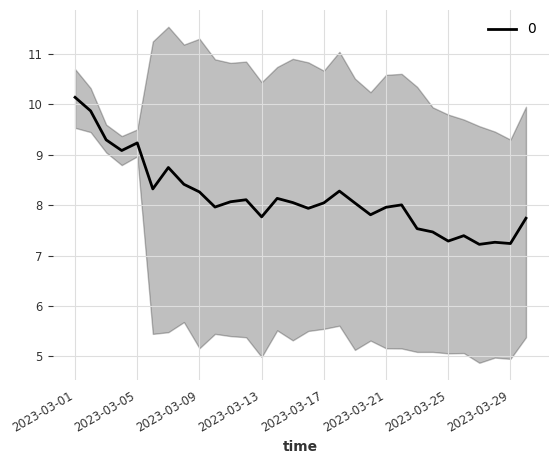

In [180]:
historical_model = HistoricalForecaster(data_preprocessor=data_preprocessor,
                          output_csv_name="historical_forecaster_output.csv",
                          validation_split_date="2023-03-01",
                          forecast_horizon=30,
                          site_id="ARIK",
                          target_variable="oxygen")
historical_model.make_forecasts()
historical_model.forecast_ts.plot()

# Now the task is to train on the historical data but use 